In [1]:
# Basic
import os
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
from joblib import dump, load
import pickle

# GLM
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.genmod.families import family
from statsmodels.stats.multitest import multipletests
 
# Modelling
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import Ridge, Lasso, RidgeCV, LassoCV, ElasticNet, LogisticRegression
from sklearn.svm import SVR, SVC
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier, StackingRegressor, StackingClassifier
from xgboost import XGBRegressor, XGBClassifier
import xgboost
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from mlxtend.regressor import StackingCVRegressor
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

# SHAP
import shap

# Mertrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, confusion_matrix, precision_score, roc_curve, recall_score, precision_recall_curve, precision_recall_fscore_support, roc_auc_score, ConfusionMatrixDisplay, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score
from scipy.stats import randint
from sklearn.metrics import classification_report

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image

# import graphviz
%matplotlib inline

# glance wd
os.getcwd()

'/home/jhou2/HSV434/LandscapeProject/HSV434-IFNG-mechanism/Code'

In [2]:
os.chdir('/home/jhou2/HSV434/LandscapeProject/HSV434-IFNG-mechanism')

### Preprocessing data for ML: 
### Feature filtering based on significant gene, one-hot/Ordinal coding categorical features, scaling

In [3]:
# Load data and selected gene
significant_genes = load('Processed/HSV434_Tcell_IFNG_mechanism_ML_UnderSampling_significant_genes')
exp_matrix_UnderSampling = load('Processed/HSV434_Tcell_IFNG_mechanism_exp_matrix_UnderSampling')

In [5]:
# Select data based on significant_genes
if 'IFNG' not in significant_genes['Gene']:
    gene_names = significant_genes['Gene'].tolist()
    # assume CellType and Status may play roles here
    columns_to_select = ['CellType_Level3', 'Status', 'IFNG_bin']
    columns_to_select.extend(gene_names)

exp_matrix_UnderSampling_select = exp_matrix_UnderSampling[columns_to_select]
exp_matrix_UnderSampling_select.head(3)

,CellType_Level3,Status,IFNG_bin,MAD2L2,RSRP1,JUN,IL12RB2,S1PR1,CSF1,AC245014_3,...,JUNB,JUND,NFKBID,ZFP36,RELB,FOSB,PPP1R15A,NKG7,UBE2S,MIR155HG
0,CD4 CM,Prior,1,0.0,1.727663,2.327763,0.0,0.000000,0.0,0.0,...,3.638110,3.949364,0.0,0.000000,0.000000,1.727663,1.727663,0.000000,1.727663,0.0
1,CD4 CM,Lesion,1,0.0,1.524025,0.000000,0.0,1.524025,0.0,0.0,...,0.000000,1.524025,0.0,2.941979,1.524025,0.000000,0.000000,3.263262,0.000000,0.0
2,CD4 CM,Post,1,0.0,0.000000,2.878519,0.0,0.000000,0.0,0.0,...,4.373788,4.042344,0.0,3.366601,0.000000,3.366601,2.878519,1.886459,0.000000,0.0


In [6]:
# Cell Type is nominal variable --> one-hot encoding
dummies_CellType = pd.get_dummies(exp_matrix_UnderSampling_select.CellType_Level3)
dummies_CellType = dummies_CellType.astype(int)
# remove Cell Type column
exp_matrix_UnderSampling_select = pd.concat([exp_matrix_UnderSampling_select.drop('CellType_Level3', axis=1), dummies_CellType], axis='columns')
exp_matrix_UnderSampling_select.head(2)

,Status,IFNG_bin,MAD2L2,RSRP1,JUN,IL12RB2,S1PR1,CSF1,AC245014_3,CD160,...,CD4 EM 3,CD4 ISG,CD4 Prolif,CD4 TRM,CD8 CM,CD8 EM 1,CD8 EM 2,CD8 ISG,CD8 TRM 1,CD8 TRM 2
0,Prior,1,0.0,1.727663,2.327763,0.0,0.000000,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,Lesion,1,0.0,1.524025,0.000000,0.0,1.524025,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# Status is Ordinal variable with inherent order --> Ordinal encoding
exp_matrix_UnderSampling_select['Status'].replace(['Prior', 'Lesion', 'Post'], [0, 1, 2], inplace=True)
exp_matrix_UnderSampling_select.head(2)

,Status,IFNG_bin,MAD2L2,RSRP1,JUN,IL12RB2,S1PR1,CSF1,AC245014_3,CD160,...,CD4 EM 3,CD4 ISG,CD4 Prolif,CD4 TRM,CD8 CM,CD8 EM 1,CD8 EM 2,CD8 ISG,CD8 TRM 1,CD8 TRM 2
0,0,1,0.0,1.727663,2.327763,0.0,0.000000,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0.0,1.524025,0.000000,0.0,1.524025,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


### Spliting data to Train and Test data And scaling 

In [8]:
# prepare data X and y
X = exp_matrix_UnderSampling_select.drop(['IFNG_bin'], axis = 1)
X.head(2)

,Status,MAD2L2,RSRP1,JUN,IL12RB2,S1PR1,CSF1,AC245014_3,CD160,XCL2,...,CD4 EM 3,CD4 ISG,CD4 Prolif,CD4 TRM,CD8 CM,CD8 EM 1,CD8 EM 2,CD8 ISG,CD8 TRM 1,CD8 TRM 2
0,0,0.0,1.727663,2.327763,0.0,0.000000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,1,0.0,1.524025,0.000000,0.0,1.524025,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
y = exp_matrix_UnderSampling_select['IFNG_bin']
y.head(2)

0    1
1    1
Name: IFNG_bin, dtype: int64

In [11]:
print(f"X data shape:{X.shape}\n",
      f"y data shape:{y.shape}")

X data shape:(5536, 135)
 y data shape:(5536,)


In [12]:
# split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
print(f"Training data X: {X_train.shape}, y: {y_train.shape}\n",
      f"Testing data X: {X_test.shape}, y: {y_test.shape}")

Training data X: (3875, 135), y: (3875,)
 Testing data X: (1661, 135), y: (1661,)


In [13]:
# Apply scaling 
# Scaling: Fit only on the training set
# scaler = MinMaxScaler(feature_range=(0, 1))
scaler = StandardScaler()

X_train_scaled = X_train.copy()

columns_to_scale = X_train_scaled.columns.difference(['Status', 
                                                      'CD4 Act', 'CD4 CM', 'CD4 EM 1', 'CD4 EM 2', 'CD4 EM 3',
                                                      'CD4 ISG', 'CD4 Prolif', 'CD4 TRM', 'CD8 CM', 'CD8 EM 1', 'CD8 EM 2',
                                                      'CD8 ISG', 'CD8 TRM 1', 'CD8 TRM 2'])
print(columns_to_scale)
X_train_scaled[columns_to_scale] = scaler.fit_transform(X_train_scaled[columns_to_scale])
X_train_scaled.head(2)

Index(['ABHD17A', 'ABLIM1', 'AC245014_3', 'ACTG1', 'ADGRG1', 'ALDOA',
       'ALOX5AP', 'ANKRD28', 'ARID5A', 'ATF3',
       ...
       'UBALD2', 'UBE2S', 'XCL1', 'XCL2', 'XYLT1', 'YIPF5', 'ZEB2', 'ZFP36',
       'ZFP36L1', 'ZYX'],
      dtype='object', length=120)


,Status,MAD2L2,RSRP1,JUN,IL12RB2,S1PR1,CSF1,AC245014_3,CD160,XCL2,...,CD4 EM 3,CD4 ISG,CD4 Prolif,CD4 TRM,CD8 CM,CD8 EM 1,CD8 EM 2,CD8 ISG,CD8 TRM 1,CD8 TRM 2
4749,2,1.658083,0.100007,-1.053833,2.007985,-0.277073,-0.361033,-0.188688,-0.197934,-0.428727,...,0,0,0,0,0,0,0,0,1,0
4808,1,-0.461597,0.196776,0.776537,-0.448011,2.829140,-0.361033,-0.188688,-0.197934,-0.428727,...,0,0,0,0,0,0,0,0,1,0


In [14]:
# Apply the transformation to validation and test sets
X_test_scaled = X_test.copy()
X_test_scaled[columns_to_scale] = scaler.transform(X_test[columns_to_scale])
X_test_scaled.head(2)

,Status,MAD2L2,RSRP1,JUN,IL12RB2,S1PR1,CSF1,AC245014_3,CD160,XCL2,...,CD4 EM 3,CD4 ISG,CD4 Prolif,CD4 TRM,CD8 CM,CD8 EM 1,CD8 EM 2,CD8 ISG,CD8 TRM 1,CD8 TRM 2
2439,1,-0.461597,1.220956,0.869149,-0.448011,-0.277073,-0.361033,-0.188688,-0.197934,-0.428727,...,0,0,0,0,1,0,0,0,0,0
4971,0,-0.461597,0.684242,-1.053833,-0.448011,-0.277073,-0.361033,-0.188688,-0.197934,1.740664,...,0,0,0,0,0,0,0,0,0,1


In [15]:
# saving split data
with open('Processed/HSV434_Tcell_IFNG_mechanism_ML_UnderSampling_Final_data.pickle', 'wb') as file:
    pickle.dump((X, X_train, X_test, X_train_scaled, X_test_scaled,
                 y, y_train, y_test), file)

## Classification models

In [16]:
with open('Processed/HSV434_Tcell_IFNG_mechanism_ML_UnderSampling_Final_data.pickle', 'rb') as file:
    X, X_train, X_test, X_train_scaled, X_test_scaled, y, y_train, y_test = pickle.load(file)

## (1) Random Forest

In [ ]:
# BayesianCV - search best parameters
n_iter = 100

rf_class_params = {'n_estimators': Integer(100, 1000),
                   'max_depth':Integer(1, 100),
                   'min_samples_split':Integer(2, 30)}

rf_class_grid = BayesSearchCV(estimator=RandomForestClassifier(),
                              search_spaces=rf_class_params,
                              n_iter=n_iter,
                              cv=5,
                              n_jobs=-1,
                              scoring='roc_auc',
                              random_state=123)

rf_class_grid.fit(X_train_scaled, y_train)

print("Best Random Forest Classifier Parameters:", rf_class_grid.best_params_)

In [19]:
# Finalize the model by applying the best parameters
RF_class_best = RandomForestClassifier(max_depth=rf_class_grid.best_params_['max_depth'], 
                                       min_samples_split=rf_class_grid.best_params_['min_samples_split'],
                                       n_estimators=rf_class_grid.best_params_['n_estimators'])
RF_class_best.fit(X_train_scaled, y_train)

# Prediction on testing data
y_pred = RF_class_best.predict(X_test_scaled)

# Get predicted probabilities for ROC AUC
y_pred_proba = RF_class_best.predict_proba(X_test_scaled)[:, 1]  # Probability of the positive class (1)

# Evaluation
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, average='binary')
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Precision: {precision:.4f}\n"
      f"Recall: {recall:.4f}\n"
      f"F1: {f1:.4f}\n"
      f"ROC_AUC: {roc_auc:.4f}")

Precision: 0.6667
Recall: 0.7181
F1: 0.6914
ROC_AUC: 0.7345


In [20]:
dump(RF_class_best, 'Model/UnderSampling_RF_class_best')

['Model/UnderSampling_RF_class_best']

In [21]:
feature_importances = RF_class_best.feature_importances_
feature_names = RF_class_best.feature_names_in_

# Create a pandas DataFrame
df_features = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the DataFrame based on the importance of the features
df_features = df_features.sort_values(by='Importance', ascending=False)

# Reset the index of the DataFrame
df_features = df_features.reset_index(drop=True)

# Display the DataFrame
df_features.head(10)

,Feature,Importance
0,JUND,0.021247
1,CD69,0.020580
2,ACTG1,0.016184
3,KLF6,0.015996
4,EEF1A1,0.015410
5,DUSP1,0.015079
6,FOS,0.014944
7,NR4A2,0.014614
8,FTH1,0.014487
9,JUNB,0.014109


In [22]:
df_features.to_csv('Results/UnderSampling_RF_importance_result.csv')

## (2) XGBoost

In [23]:
# Bayesian CV - search best parameters
n_iter = 100

xgb_class_params = {'n_estimators': Integer(100, 1000),
                    'max_depth':Integer(1, 100),
                    'learning_rate':Real(0.0001, 0.1, prior='log-uniform')}

xgb_class_grid = BayesSearchCV(estimator = XGBClassifier(),
                               search_spaces = xgb_class_params,
                               n_iter = n_iter,
                               cv = 5,
                               n_jobs = -1,
                               scoring = 'roc_auc',
                               random_state = 123)

xgb_class_grid.fit(X_train_scaled, y_train)

print("Best XGB Classifier Parameters:", xgb_class_grid.best_params_)

Best XGB Classifier Parameters: OrderedDict([('learning_rate', 0.09999999999999999), ('max_depth', 1), ('n_estimators', 946)])


In [24]:
# Finalize the model by appling the best parameters
xgb_class_best = XGBClassifier(max_depth = xgb_class_grid.best_params_['max_depth'],
                               learning_rate = xgb_class_grid.best_params_['learning_rate'],
                               n_estimators = xgb_class_grid.best_params_['n_estimators'])
xgb_class_best.fit(X_train_scaled, y_train)

# prediction on testing data
y_pred = xgb_class_best.predict(X_test_scaled)

# Get predicted probabilities for ROC AUC
y_pred_proba = xgb_class_best.predict_proba(X_test_scaled)[:, 1]  # Probability of the positive class (1)

# Evaluation
precision, recall, f, support = precision_recall_fscore_support(y_test, y_pred, average='binary')
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Precision: {precision:.4f}\n"
      f"Recall: {recall:.4f}\n"
      f"F1: {f1:.4f}\n"
      f"ROC_AUC: {roc_auc:.4f}")

Precision: 0.6634
Recall: 0.6627
F1: 0.6914
ROC_AUC: 0.7278


In [25]:
dump(xgb_class_best, 'Model/UnderSampling_XGB_class_best')

['Model/UnderSampling_XGB_class_best']

In [26]:
feature_importances = xgb_class_best.feature_importances_
feature_names = xgb_class_best.feature_names_in_

# Create a pandas DataFrame
df_features = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the DataFrame based on the importance of the features
df_features = df_features.sort_values(by='Importance', ascending=False)

# Reset the index of the DataFrame
df_features = df_features.reset_index(drop=True)

# Display the DataFrame
df_features.head(5)

,Feature,Importance
0,CD69,0.067173
1,CCL4,0.049080
2,JUND,0.041839
3,NR4A1,0.030677
4,LAG3,0.026325


In [27]:
df_features.to_csv('Results/UnderSampling_XGB_importance_result.csv')

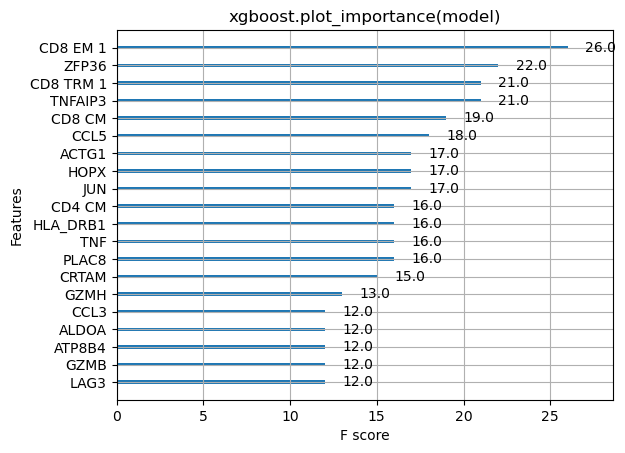

In [28]:
xgboost.plot_importance(xgb_class_best, max_num_features = 20)
pl.title("xgboost.plot_importance(model)")
pl.show()

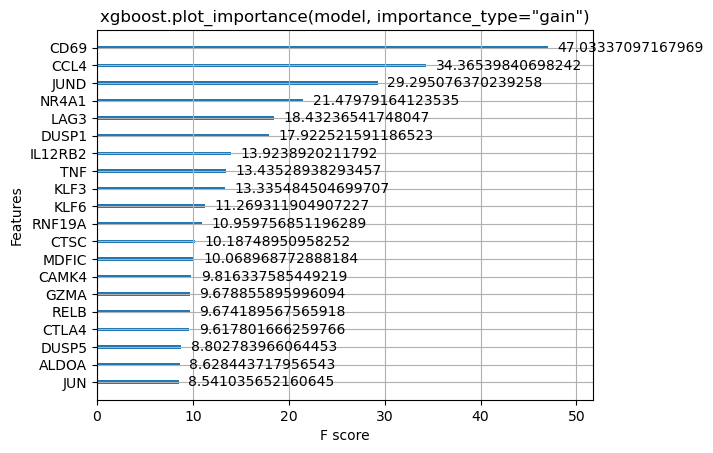

In [29]:
xgboost.plot_importance(xgb_class_best, max_num_features = 20, importance_type="gain")
pl.title('xgboost.plot_importance(model, importance_type="gain")')
pl.show()

## (3) SVM

In [30]:
# Bayesian CV - search best parameters
n_iter = 100
svc_class_param = {'C': Real(0.1, 1000, prior='log-uniform'),
                   'gamma':Real(0.0001, 1, prior='log-uniform')}

svc_class_grid = BayesSearchCV(estimator = SVC(kernel = 'rbf', probability=True),
                               search_spaces = svc_class_param,
                               n_iter = n_iter,
                               cv = 5,
                               n_jobs = -1,
                               scoring = 'roc_auc',
                               random_state = 123)
svc_class_grid.fit(X_train_scaled, y_train)
print("Best SVM Parameters:", svc_class_grid.best_params_)

Best SVM Parameters: OrderedDict([('C', 488.9249544757395), ('gamma', 0.0001)])


In [31]:
# Finalize the model by appling the best parameters
svc_class_best = SVC(C = svc_class_grid.best_params_['C'], 
                     gamma = svc_class_grid.best_params_['gamma'], 
                     kernel = 'rbf', 
                     probability=True)
svc_class_best.fit(X_train_scaled, y_train)

# prediction on testing data
y_pred = svc_class_best.predict(X_test_scaled)

# Get predicted probabilities for ROC AUC
y_pred_proba = svc_class_best.predict_proba(X_test_scaled)[:, 1]  # Probability of the positive class (1)

# Evaluation
precision, recall, f, support = precision_recall_fscore_support(y_test, y_pred, average='binary')
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Precision: {precision:.4f}\n"
      f"Recall: {recall:.4f}\n"
      f"F1: {f1:.4f}\n"
      f"ROC_AUC: {roc_auc:.4f}")

Precision: 0.6825
Recall: 0.6940
F1: 0.6914
ROC_AUC: 0.7514


In [32]:
dump(svc_class_best, 'Model/UnderSampling_svc_class_best')

['Model/UnderSampling_svc_class_best']

# Stacking models

In [33]:
# load data
with open('Processed/HSV434_Tcell_IFNG_mechanism_ML_UnderSampling_Final_data.pickle', 'rb') as file:
    X, X_train, X_test, X_train_scaled, X_test_scaled, y, y_train, y_test = pickle.load(file)

In [34]:
# load pre-optimized models
RF_class_best = load('Model/UnderSampling_RF_class_best')
xgb_class_best = load('Model/UnderSampling_XGB_class_best')
svc_class_best = load('Model/UnderSampling_svc_class_best')

In [35]:
# Define the base estimators
base_estimators = [('RF', RF_class_best),
                   ('XGBoost', xgb_class_best),
                   ('SVM', svc_class_best)]

# Define the meta-model (e.g., logistic regression)
meta_model = LogisticRegression(random_state=42, max_iter=1000)

In [36]:
# Create the stacking classifier
stacked_model = StackingClassifier(estimators = base_estimators, 
                                   final_estimator = meta_model,
                                   cv = 5,  # internal cross-validation for meta-model
                                   n_jobs = -1)

In [39]:
meta_params = {'final_estimator__C': Real(1e-3, 1e3, prior='log-uniform')}

stacked_grid = BayesSearchCV(estimator = stacked_model,
                             search_spaces = meta_params,
                             n_iter = 50,
                             cv = 5,
                             n_jobs = -1,
                             scoring = 'roc_auc',
                             random_state = 42)

stacked_grid.fit(X_train_scaled, y_train)

print(f"Best Meta-Model Parameters: {stacked_grid.best_params_}")

Best Meta-Model Parameters: OrderedDict([('final_estimator__C', 1.0735617023281263)])


In [40]:
# Access the best model with optimized parameters
best_stacked_model = stacked_grid.best_estimator_

# Now, you can use the best model to fit on the data
best_stacked_model.fit(X_train_scaled, y_train)

# You can then make predictions with the optimized stacked model
y_pred = best_stacked_model.predict(X_test_scaled)

# Get predicted probabilities for ROC AUC
y_pred_proba = best_stacked_model.predict_proba(X_test_scaled)[:, 1]

# Evaluation
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, average='binary')
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Precision: {precision:.4f}\n"
      f"Recall: {recall:.4f}\n"
      f"F1: {f1:.4f}\n"
      f"ROC_AUC: {roc_auc:.4f}")

Precision: 0.6835
Recall: 0.7024
F1: 0.6928
ROC_AUC: 0.7494


In [41]:
dump(best_stacked_model, 'Model/UnderSampling_Stacked_class_best')

['Model/UnderSampling_Stacked_class_best']